# Humid Heat Metrics

## Overview

Humid heat metrics index temperature and humidity, which is often more useful than comparing either variable alone when considering perceived temperature as they together affect the human body's ability to cool itself down. Humid heat metrics are especially important for the safety of outside workers, the elderly, or otherwise high-risk high-exposure individuals. 

Wet Bulb Globe Temperature (WBGT) is a measure of heat stress. The equation for outdoor ($WBGT_{OD}$) and indoor/shaded ($WBGT_{ID}$) WBGTs are:

$WBGT_{od} = 0.7*T_{nwb} + 0.2*T_g + 0.1*T_a$

$WBGT_{id} = 0.7*T_{nwb} + 0.3*T_g$

where $T_a$ refers to Dry Bulb Ambient Temperatue, $T_{nwb}$ is the Natural Wet Bulb Temperature wet bulb temperature with exposure to wind and sun, and $T_g$ is the Globe Temperature temperature taken from inside a copper globe painted black and exposed to the sun.

However this formula is complicated by the reality that Natural Wet Bulb Temperature and Globe Temperature are not always readily available variables from weather stations or atmospheric models.

In this notebook we will demonstrate the Australian Bureau of Meteorology (ABM) and Bernard methods of predicting wet bulb global temperature with a focus on the July 1995 Chicago heatwave.

For our analysis, we have ERA5 renanalysis data for the lower contiguous United States (50N, 24S, -66E, -125W) from July 1995 with the variables: 2-meter temperature, 2-meter dew point temperature, surface pressure, and *u*/*v* wind components.

---

In [1]:
import geocat.datafiles as gdf
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
era5 = xr.open_dataset(gdf.get("netcdf_files/era5_1995-07-14T12"))
era5.u10

<xarray.DataArray 'u10' (latitude: 105, longitude: 237)> Size: 100kB
[24885 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 948B -125.0 -124.8 -124.5 ... -66.25 -66.0
  * latitude   (latitude) float32 420B 50.0 49.75 49.5 49.25 ... 24.5 24.25 24.0
    time       datetime64[ns] 8B ...
Attributes:
    units:      m s**-1
    long_name:  10 metre U wind component

In [3]:
# Convert from Kelvin to Celsius 

era5['t2m_C'] = era5['t2m'] - 273.15 
era5['d2m_C'] = era5['d2m'] - 273.15

In [4]:
# Chicago coordinates
lat_chicago = 41.8781
lon_chicago = -87.6298

## Australian Bureau of Meteorology (ABM)

The Australian Bureau of Meteorology's method of estimating Wet Bulb Global Temperature is attractive due to its simplicity. It only requires temperature and water pressure (or relative humidity). Here we use the Clausius-Clapeyron equation to calculate relative humidity from temperature and dewpoint. 

This method tends to overpredict WBGT compared to other models and assumes full sunlight and light breeze.

In [5]:
def calc_abm_wbgt(t_a, rh):
    p = (rh/100) * 6.105 * np.exp(17.27 * t_a / (237.7 + t_a)) # water vapor pressure [hPa]
    wbgt = (0.567 * t_a) + (0.393 * p) + 3.94
    return wbgt

To use our ERA5 data in this equation, we need to first approximate relative humidity using the Clausius-Clapeyron Equation:

In [6]:
def _calc_saturation_vapor_pressure(t_a): # Magnus-Tetens Approximation\
    e_sat = 6.11 * np.exp((17.625 * t_a) / (t_a + 243.04)) # Saturation Vapor Pressure in hPa
    return e_sat

def calc_relative_humidity_era5(t_a, t_d):
    e_sat = _calc_saturation_vapor_pressure(t_a) # saturation vapor pressure
    e = 6.11*np.exp(17.625 * t_d / (243.04 + t_d)) # vapor pressure from dew point temp
    rh = 100 * e / e_sat  # Clausius-Clapeyron equation
    return rh

rh = calc_relative_humidity_era5(era5.t2m_C, era5.d2m_C)

In [7]:
wbgt_abm = calc_abm_wbgt(era5.t2m_C, rh)
wbgt_abm

<xarray.DataArray (latitude: 105, longitude: 237)> Size: 100kB
array([[17.870842, 16.18047 , 14.57531 , ..., 19.192104, 18.33654 ,
        18.172283],
       [18.569607, 17.136898, 17.365152, ..., 18.539204, 18.473352,
        18.543066],
       [17.96876 , 18.647879, 18.880539, ..., 18.72899 , 18.71052 ,
        18.844599],
       ...,
       [21.672411, 21.692675, 21.689726, ..., 30.19241 , 29.973494,
        29.821829],
       [21.93418 , 21.912344, 21.907938, ..., 30.340406, 30.14428 ,
        30.02978 ],
       [22.193027, 22.14459 , 22.129972, ..., 30.43058 , 30.351868,
        30.227827]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 948B -125.0 -124.8 -124.5 ... -66.25 -66.0
  * latitude   (latitude) float32 420B 50.0 49.75 49.5 49.25 ... 24.5 24.25 24.0
    time       datetime64[ns] 8B 1995-07-14T12:00:00

Text(-84.6298, 38.8781, 'Chicago')

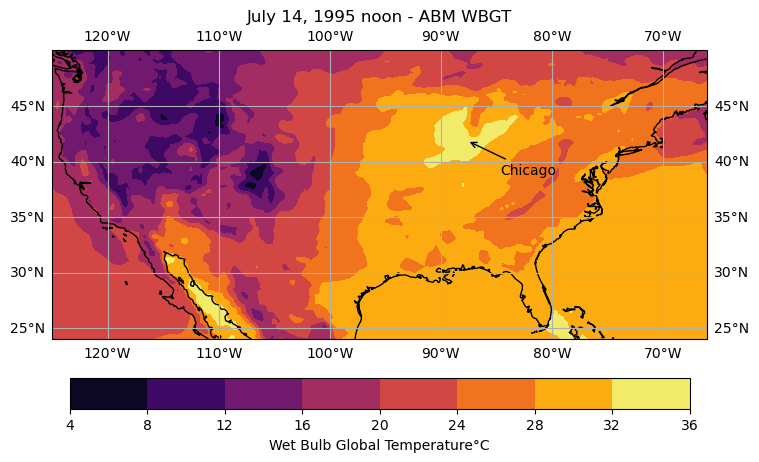

In [8]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

c = plt.contourf(era5.longitude, era5.latitude, wbgt_abm, cmap='inferno')

ax.coastlines()
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.1, shrink=0.8)
cbar.set_label('Wet Bulb Global Temperature' + u'\N{DEGREE SIGN}'+ 'C')

ax.set_title('July 14, 1995 noon - ABM WBGT')

ax.annotate('Chicago', xy=(lon_chicago, lat_chicago), xytext=(lon_chicago + 3, lat_chicago - 3),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            transform=ccrs.PlateCarree())

# Bernard

Bernard's semi-empirical formula approximates Natural Wet Bulb temperature based on heat exchange of a wetted wick exposed to sun and wind based on measurements of common United States summertime environmental conditions.

This is considered an indoor WBGT temperature because it does not include any strong radiative sources in the calculation.

In Bernard's analysis wind speeds less than 0.3 m/s are not included since the field of humid heat metrics is primarily concenered with workers and an outdoor worker is unlikely to be stationary. Apparent wind speeds are assumed to be at least 1 m/s.

This formula utilizes thermodynamic Wet Bulb Temperature ($T_{pwb}$), which is a wet bulb temperature in the shade and fanned or rotated. This is the wet bulb typically used for dew point calculations, and can be iteratively derived from temeperature ($T_a$) and dewpoint ($T_d$).

In [9]:
# Newton-Raphson iterative method for t_pwb
def _calc_tpwb_scalar(t_a, t_d):
    def f(t_pwb):
        e_d = 6.106 * np.exp(17.27 * t_d / (237.3 + t_d))  # hPa
        e_w = 6.106 * np.exp(17.27 * t_pwb / (237.3 + t_pwb))  # hPa
        return 1556 * e_d - 1.484 * e_d * t_pwb - 1556 * e_w + 1.484 * e_w * t_pwb + 1010 * (t_a - t_pwb)
    
    def f_prime(t_pwb, h=1e-5): # numerical derivative
        return (f(t_pwb + h) - f(t_pwb - h)) / (2 * h)
    
    t_pwb = t_d # initial guess
    for i in range(100):
        f_value = f(t_pwb)
        f_prime_value = f_prime(t_pwb)
        
        if f_prime_value == 0:
            raise ValueError("Zero derivative encountered; no solution for t_pwb found.")
        
        t_pwb_new = t_pwb - f_value / f_prime_value
        
        if abs(t_pwb_new - t_pwb) < 1e-6: # tolerance
            return t_pwb_new
        
        t_pwb = t_pwb_new
    
    raise ValueError("Maximum iterations reached; no solution found for t_pwb.")


# Apply function over grid
def _calc_tpwb(t_a, t_d):
    return xr.apply_ufunc(
        _calc_tpwb_scalar, 
        t_a, 
        t_d, 
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float]
    )

# Bernard formula for WBGT
def calc_bernard_wbgt(t_a, t_pwb, v):
    
    if np.all(v < 0.3): # m/s
        return np.nan  # Return NaN where velocity is below the threshold
    elif np.all((0.3 <= v) & (v <= 3)):
        wbgt = (0.67 * t_pwb) + (0.33 * t_a) - (0.48 * np.log10(v) * (t_a - t_pwb))
    else:
        wbgt = (0.7 * t_pwb) + (0.3 * t_a)
    
    return wbgt


In [10]:
v = np.sqrt(era5.u10**2 + era5.v10**2) # combine u and v wind components
t_pwb = _calc_tpwb(era5.t2m_C, era5.d2m_C)

wbgt_bernard = calc_bernard_wbgt(era5.t2m_C, t_pwb, v)
wbgt_bernard

<xarray.DataArray (latitude: 105, longitude: 237)> Size: 199kB
array([[13.695178  , 11.89261844, 10.13768247, ..., 14.99941441,
        14.13420708, 13.9702521 ],
       [14.41540541, 12.91479056, 13.15184303, ..., 14.35261484,
        14.28806844, 14.36000138],
       [13.78972268, 14.48720268, 14.72255427, ..., 14.55733826,
        14.54146855, 14.67784217],
       ...,
       [17.48846196, 17.50782951, 17.50468536, ..., 24.95087907,
        24.79825911, 24.69035188],
       [17.73965528, 17.71867846, 17.71419749, ..., 25.05317913,
        24.91488147, 24.82649699],
       [17.98647702, 17.94030654, 17.9263186 , ..., 25.11073911,
        25.0451701 , 24.94564864]])
Coordinates:
  * longitude  (longitude) float32 948B -125.0 -124.8 -124.5 ... -66.25 -66.0
  * latitude   (latitude) float32 420B 50.0 49.75 49.5 49.25 ... 24.5 24.25 24.0
    time       datetime64[ns] 8B 1995-07-14T12:00:00

Text(-84.6298, 38.8781, 'Chicago')

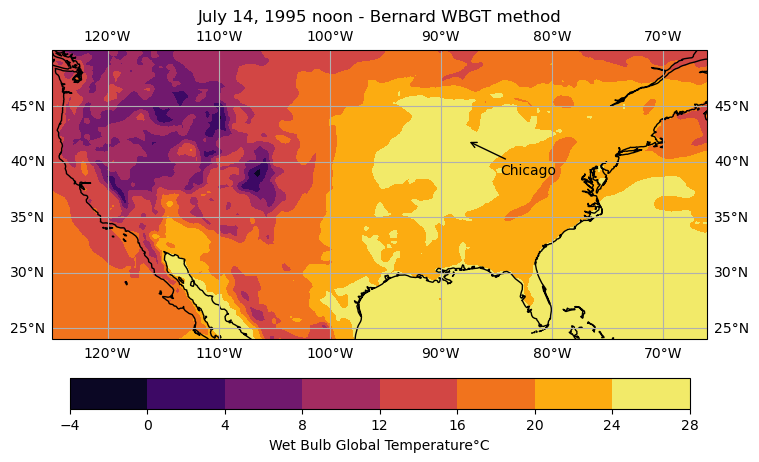

In [11]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

c = plt.contourf(era5.longitude, era5.latitude, wbgt_bernard, cmap='inferno')

ax.coastlines()
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.1, shrink=0.8)
cbar.set_label('Wet Bulb Global Temperature' + u'\N{DEGREE SIGN}'+ 'C')

ax.set_title('July 14, 1995 noon - Bernard WBGT method')

ax.annotate('Chicago', xy=(lon_chicago, lat_chicago), xytext=(lon_chicago + 3, lat_chicago - 3),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            transform=ccrs.PlateCarree())

## Comparing methods

The ABM model tends to overpredict WBGT compared to other models. When comparing our output from both ABM and Bernard, ABM is indeen higher by 4 - 7 degrees Celsius.

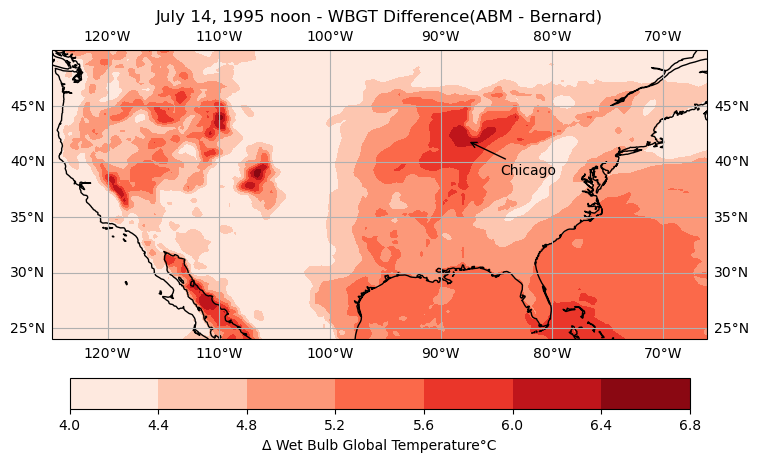

In [12]:
from matplotlib.colors import TwoSlopeNorm

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

diff = wbgt_abm - wbgt_bernard

c = plt.contourf(era5.longitude, era5.latitude, diff, cmap='Reds')

ax.coastlines()
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.1, shrink=0.8)
cbar.set_label('\N{GREEK CAPITAL LETTER DELTA} Wet Bulb Global Temperature' + u'\N{DEGREE SIGN}'+ 'C')
ax.set_title('July 14, 1995 noon - WBGT Difference(ABM - Bernard)')

ax.annotate('Chicago', xy=(lon_chicago, lat_chicago), xytext=(lon_chicago + 3, lat_chicago - 3),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            transform=ccrs.PlateCarree());

Since the main difference between the ABM and Bernard methods is that Bernard includes wind speed, let's do a visual inspection with the wind quivers overlaid on our previous plot.

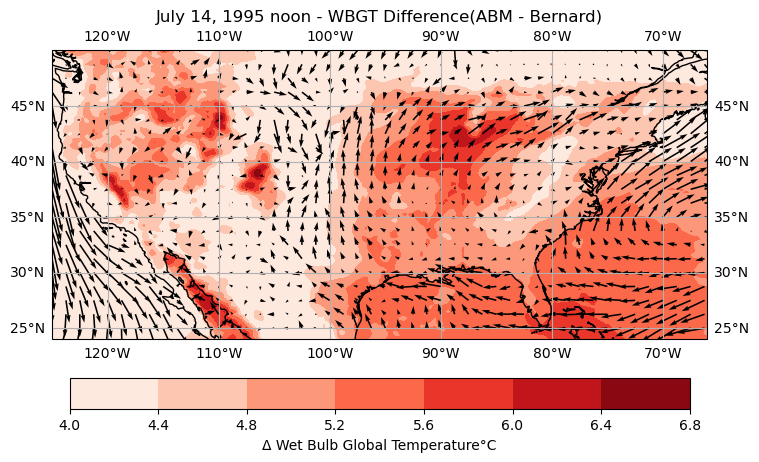

In [13]:
from matplotlib.colors import TwoSlopeNorm

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

c = plt.contourf(era5.longitude, era5.latitude, diff, cmap='Reds')

ax.coastlines()
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.1, shrink=0.8)
cbar.set_label('\N{GREEK CAPITAL LETTER DELTA} Wet Bulb Global Temperature' + u'\N{DEGREE SIGN}'+ 'C')
ax.set_title('July 14, 1995 noon - WBGT Difference(ABM - Bernard)')


# Add the u and v wind components as quiver vectors
u = era5['u10'].values[::5, ::5]
v = era5['v10'].values[::5, ::5]
lon = era5.longitude.values[::5]
lat = era5.latitude.values[::5]
q = ax.quiver(lon, lat, u, v, transform=ccrs.PlateCarree(), scale=200);

Additional methods that may be considered and investigated in the future are: Hunter, Tonouchi, Liljegren, Li.

## References:

- Thomas E. Bernard (1999) Prediction of Workplace Wet Bulb Global Temperature, *Applied Occupational and Environmental Hygiene*, 14:2, 126-134, DOI:10.1080/104732299303296
- Lemke and Kjellstrom (2012) Calculating Workplace WBGT from Meteorological Data: A Tool for Climate Change Assessment, *Industrial Health* , 50, 267–278